In [1]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import pandas as pd
import time
# from concurrent.futures import ProcessPoolExecutor

from common.log import *
from common.config import Config
from spider.spider_nasdaq import Spider_nasdaq

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from pandas_highcharts.core import serialize
from pandas_highcharts.display import display_charts

CONF = Config().data[0]
MONGODB = CONF['MONGODB']
NASDAQ = CONF['NASDAQ']
CRYPTOCURRENCY = CONF['CRYPTOCURRENCY']
NASDAQ100 = CONF['NASDAQ100']

pd

<module 'pandas' from 'd:\\python3\\lib\\site-packages\\pandas\\__init__.py'>

In [2]:
%%time

spider = Spider_nasdaq()
timeframe = '10y'
ignore = True

# for symbol in NASDAQ100:
for symbol in ['NDX']:
#     if symbol == 'WDAY':
#         ignore = False
#     if ignore:
#         continue
#     datafile = spider.get_stock_data(symbol, timeframe)
#     print(datafile)
    pass

Wall time: 0 ns


In [3]:
%%time

### 业务设置

start_date = '2008-06-02'
start_date = '2017-01-03'
end_date = '2018-05-01'


Wall time: 0 ns


In [4]:
%%time

stock_df_dict = {}

for symbol in NASDAQ100[:]:
    stock_data_file = '../database/market/%s.csv' % symbol
    stock_df = pd.read_csv(stock_data_file)

    # 筛选字段
    stock_df = stock_df.loc[:, ['date', 'open', 'close']]

    # 去掉Nasdaq行情首行的当天行情
    if symbol in NASDAQ:
        stock_df = stock_df.drop([0])

    # 抛弃空值异常值
    stock_df.dropna(axis=0, how='any', inplace=True)

    # 格式化日期
    # 1.48 s ± 45.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
#     stock_df['date'] = stock_df['date'].apply(lambda x: pd.Period(x, freq='D'))

    # 445 ms ± 17.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
    stock_df = stock_df.assign(date=pd.to_datetime(stock_df['date']))  # need .index.to_period('D')

    # 476 ms ± 46.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
#     stock_df['date'] = pd.to_datetime(stock_df['date'])  # need .index.to_period('D')
    
    # 转换字段格式
#     stock_df = stock_df.astype(dtype={'volume': 'float64'})

    # 用日期作索引，日期升序排序
    # 95.1 µs ± 1.58 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
    stock_df = stock_df[::-1]
    
    # 407 µs ± 5.07 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
#     %timeit stock_df.set_index(['date'], inplace=False)

    # Wall time: 500 µs
    stock_df.set_index(['date'], inplace=True)
    
    # 305 µs ± 2.75 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
#     stock_df = stock_df.sort_index(axis=0, ascending=True)
    
    # 822 µs ± 41.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
    stock_df.index = stock_df.index.to_period('D')

    # 计算涨跌幅
    stock_df['pct_change'] = stock_df.close.pct_change(1)
    stock_df['open_pct_change'] = stock_df.open.pct_change(1)
    
    # 减少数据
#     stock_df = stock_df['2016-01-01':]
    
    stock_df_dict[symbol] = stock_df
    
#     print(stock_df.head(10))
#     print(stock_df.dtypes)
#     print(stock_df.index[0])
#     print(type(stock_df.index[0]))

Wall time: 58.5 s


In [5]:
%%time

show_df = None
show_df = stock_df_dict['NDX'].copy()

Wall time: 2 ms


In [6]:
%%time
# %%lprun

### Turtle
TURTLE_POS = 10
TURTLE_BUY_N = 20
TURTLE_SELL_N = 20

is_happy_money = False
HAPPY_MONEY = 0
PROPERTY = 100000
CASH = 100000
hold = []
order_df = pd.DataFrame(columns=['buy_date', 'symbol', 'buy_count', 'buy_price', 'sell_date', 'sell_price', 'profit', 'cash', 'property'])
count_day = 0
yesterday = None

# show_df['CASH_T'] = pd.np.nan
# show_df['PROPERTY_T'] = pd.np.nan

rolling_min_dict = {}
rolling_max_dict = {}

for symbol in NASDAQ100:
    rolling_min_dict[symbol] = stock_df_dict[symbol].loc[:, 'open'].rolling(TURTLE_SELL_N).min()
    rolling_max_dict[symbol] = stock_df_dict[symbol].loc[:, 'open'].rolling(TURTLE_BUY_N).max()
    

for today in pd.period_range(start=start_date, end=end_date, freq='D'):
# for today in stock_df_dict['NDX'].index:
    count_day += 1
    
    if yesterday is None:
        yesterday = today
        continue

    if today not in stock_df_dict['NDX'].index:
        continue

    if is_happy_money:        
        if PROPERTY > 100000 * 2:
            hold = []
            HAPPY_MONEY += 50000
            PROPERTY -= 50000
            CASH = PROPERTY
    
    for idx in order_df.index:
        order = order_df.iloc[idx]
        
        if order['sell_price'] != 0:
            continue
        
        is_sell = (stock_df_dict[order['symbol']].loc[today, 'open'] == rolling_min_dict[order['symbol']].loc[today])
#         is_sell = False
        
        if is_sell:
            CASH += stock_df_dict[order['symbol']].loc[today, 'open'] * order['buy_count']
            print('%s 售出 SELL %s * %d @ %f CASH=%d PROPERTY=%d' 
                  % (today, order['symbol'], order['buy_count'], stock_df_dict[order[1]].loc[today, 'open'], CASH, PROPERTY))
            order_df.loc[idx, 'sell_date'] = today
            order_df.loc[idx, 'sell_price'] = stock_df_dict[order[1]].loc[today, 'open']
            order_df.loc[idx, 'profit'] = (order_df.loc[idx, 'sell_price'] - order_df.loc[idx, 'buy_price']) * order_df.loc[idx, 'buy_count']
    
    for symbol in NASDAQ100:
        if symbol == 'NDX':
            continue
        
        if today not in stock_df_dict[symbol].index:
            continue
        
        if count_day < 20:
            is_buy = False
        else:
            is_buy = (stock_df_dict[symbol].loc[today, 'open'] == rolling_max_dict[symbol].loc[today])
#             is_buy = (stock_df_dict[symbol].loc[yesterday, 'close'] == (stock_df_dict[symbol].loc[:, 'close'].rolling(N).max()).loc[yesterday])
        
        if is_buy:
            if CASH < 100000 / TURTLE_POS:
                continue
            buy = int(100000 / TURTLE_POS / stock_df_dict[symbol].loc[today, 'open'])
            if buy == 0:
                continue
            CASH -= stock_df_dict[symbol].loc[today, 'open'] * buy
            print('%s 进场 BUY  %s * %d @ %f CASH=%d PROPERTY=%d' % 
                  (today, symbol, buy, stock_df_dict[symbol].loc[today, 'open'], CASH, PROPERTY))
            order_df = order_df.append(
                {
                    'buy_date': today,
                    'symbol': symbol,
                    'buy_count': buy,
                    'buy_price': stock_df_dict[symbol].loc[today, 'open'],
                    'sell_date': pd.np.nan,
                    'sell_price': 0,
                    'profit': 0,
                    'cash': 0,
                    'property': 0,
                },
                ignore_index=True
            )
            
    
    show_df.loc[today, 'CASH_TURTLE'] = CASH
    PROPERTY = CASH + sum([stock_df_dict[order_df.loc[idx, 'symbol']].loc[today, 'open'] * order_df.loc[idx, 'buy_count'] for idx in order_df.loc[order_df['sell_price']==0].index])
    show_df.loc[today, 'PROPERTY_TURTLE'] = PROPERTY

    yesterday = today
            

print(CASH)
print(HAPPY_MONEY)
print(PROPERTY)
print(hold)

s_p = stock_df_dict['NDX'].loc[start_date, 'open']
e_p = stock_df_dict['NDX'].loc[end_date, 'open']
print('NDX', s_p, e_p, e_p / s_p)


2017-01-23 进场 BUY  ADBE * 90 @ 110.710000 CASH=90036 PROPERTY=100000
2017-01-23 进场 BUY  GOOGL * 12 @ 831.610000 CASH=80056 PROPERTY=100000
2017-01-23 进场 BUY  ADSK * 122 @ 81.390000 CASH=70127 PROPERTY=100000
2017-01-23 进场 BUY  AVGO * 52 @ 191.010000 CASH=60194 PROPERTY=100000
2017-01-23 进场 BUY  CHKP * 102 @ 97.270000 CASH=50273 PROPERTY=100000
2017-01-23 进场 BUY  CMCSA * 271 @ 36.775000 CASH=40307 PROPERTY=100000
2017-01-23 进场 BUY  CSX * 223 @ 44.660000 CASH=30347 PROPERTY=100000
2017-01-23 进场 BUY  EXPE * 83 @ 120.000000 CASH=20387 PROPERTY=100000
2017-01-23 进场 BUY  FAST * 195 @ 51.210000 CASH=10401 PROPERTY=100000
2017-01-23 进场 BUY  KLAC * 122 @ 81.690000 CASH=435 PROPERTY=100000
2017-02-21 售出 SELL EXPE * 83 @ 118.820000 CASH=10297 PROPERTY=104084
2017-02-21 进场 BUY  ADBE * 83 @ 119.730000 CASH=360 PROPERTY=104084
2017-03-06 售出 SELL CMCSA * 271 @ 37.070000 CASH=10406 PROPERTY=105288
2017-03-06 进场 BUY  AMGN * 55 @ 179.550000 CASH=530 PROPERTY=105288
2017-03-07 售出 SELL CHKP * 102 @ 98.630

2018-02-08 进场 BUY  HAS * 99 @ 101.010000 CASH=69033 PROPERTY=138546
2018-02-09 售出 SELL CHTR * 25 @ 351.410000 CASH=77818 PROPERTY=137970
2018-02-09 售出 SELL LBTYK * 275 @ 33.700000 CASH=87086 PROPERTY=137970
2018-02-15 进场 BUY  CSCO * 221 @ 45.065000 CASH=77126 PROPERTY=136472
2018-02-15 进场 BUY  CTSH * 124 @ 80.290000 CASH=67170 PROPERTY=136472
2018-02-15 进场 BUY  SWKS * 95 @ 104.980000 CASH=57197 PROPERTY=136472
2018-02-15 进场 BUY  WDAY * 82 @ 121.500000 CASH=47234 PROPERTY=136472
2018-02-16 进场 BUY  ADBE * 49 @ 202.520000 CASH=37311 PROPERTY=137899
2018-02-16 进场 BUY  CTSH * 122 @ 81.490000 CASH=27369 PROPERTY=137899
2018-02-16 进场 BUY  SIRI * 1615 @ 6.190000 CASH=17372 PROPERTY=137899
2018-02-16 进场 BUY  SYMC * 360 @ 27.750000 CASH=7382 PROPERTY=137899
2018-03-09 售出 SELL HAS * 99 @ 91.080000 CASH=16399 PROPERTY=143896
2018-03-09 进场 BUY  ATVI * 130 @ 76.855000 CASH=6408 PROPERTY=143896
2018-03-23 售出 SELL ATVI * 136 @ 69.860000 CASH=15909 PROPERTY=139726
2018-03-23 售出 SELL SWKS * 96 @ 105.320

In [7]:
sum(list(order_df['profit']))
# [order_df.loc[idx, 'buy_count'] for idx in order_df.loc[order_df['sell_price']==0].index]
# sum([stock_df_dict[order_df.loc[idx, 'symbol']].loc[today, 'open'] * order_df.loc[idx, 'buy_count'] for idx in order_df.loc[order_df['sell_price']==0].index])
order_df
# order_df.loc[order_df['sell_price']==0]

34247.000000000022

,buy_date,symbol,buy_count,buy_price,sell_date,sell_price,profit,cash,property
0,2017-01-23,ADBE,90,110.710,2017-08-11,145.25,3108.6,0,0
1,2017-01-23,GOOGL,12,831.610,2017-03-23,841.39,117.36,0,0
2,2017-01-23,ADSK,122,81.390,2017-04-06,83.49,256.2,0,0
3,2017-01-23,AVGO,52,191.010,2017-04-12,215.67,1282.32,0,0
4,2017-01-23,CHKP,102,97.270,2017-03-07,98.63,138.72,0,0
5,2017-01-23,CMCSA,271,36.775,2017-03-06,37.07,79.945,0,0
6,2017-01-23,CSX,223,44.660,2017-03-20,46.96,512.9,0,0
7,2017-01-23,EXPE,83,120.000,2017-02-21,118.82,-97.94,0,0
8,2017-01-23,FAST,195,51.210,2017-03-27,50.11,-214.5,0,0
9,2017-01-23,KLAC,122,81.690,2017-04-17,94.52,1565.26,0,0


In [8]:
%%time
# %xmode

### Turtle + BT
TURTLE_POS = 10
TURTLE_BUY_N = 20
TURTLE_SELL_N = 20

is_happy_money = False
START_MONEY = 100000
HAPPY_MONEY = 0
PROPERTY = START_MONEY
CASH = START_MONEY
hold = []
order_df_TB = pd.DataFrame(
    columns=['buy_date', 'strategy', 'symbol', 'buy_count', 'buy_price', 'expect', 'sell_date', 'sell_price', 'profit', 'cash', 'property']
)
count_day = 0
yesterday = None

# show_df['CASH_T'] = pd.np.nan
# show_df['PROPERTY_T'] = pd.np.nan

rolling_min_dict = {}
rolling_max_dict = {}

for symbol in NASDAQ100:
    rolling_min_dict[symbol] = stock_df_dict[symbol].loc[:, 'open'].rolling(TURTLE_SELL_N).min()
    rolling_max_dict[symbol] = stock_df_dict[symbol].loc[:, 'open'].rolling(TURTLE_BUY_N).max()
    

for today in pd.period_range(start=start_date, end=end_date, freq='D'):
# for today in stock_df_dict['NDX'].index:
    count_day += 1
    
    if yesterday is None:
        yesterday = today
        continue

    if today not in stock_df_dict['NDX'].index:
        continue

    if is_happy_money:        
        if PROPERTY > 100000 * 2:
            hold = []
            HAPPY_MONEY += 50000
            PROPERTY -= 50000
            CASH = PROPERTY
    
    for idx in order_df_TB.index:
        order = order_df_TB.iloc[idx]
        
        if order['sell_price'] != 0:
            continue
        
        if order['strategy'] == 'TURTLE':
            is_sell = stock_df_dict[order['symbol']].loc[today, 'open'] == rolling_min_dict[order['symbol']].loc[today]
        elif order['strategy'] == 'BT':
            is_sell = stock_df_dict[order['symbol']].loc[today, 'open'] > order['expect']
            is_sell = is_sell or stock_df_dict[order['symbol']].loc[today, 'open'] / order['buy_price'] < 0.8
            is_sell = is_sell or today - order['buy_date'] > 30
        
        if is_sell:
            CASH += stock_df_dict[order['symbol']].loc[today, 'open'] * order['buy_count']
            print('%s 售出 %s SELL %s * %d @ %f CASH=%d PROPERTY=%d' 
                  % (today, order['strategy'], order['symbol'], order['buy_count'], stock_df_dict[order['symbol']].loc[today, 'open'], CASH, PROPERTY))
            order_df_TB.loc[idx, 'sell_date'] = today
            order_df_TB.loc[idx, 'sell_price'] = stock_df_dict[order['symbol']].loc[today, 'open']
            order_df_TB.loc[idx, 'profit'] = (order_df_TB.loc[idx, 'sell_price'] - order_df_TB.loc[idx, 'buy_price']) * order_df_TB.loc[idx, 'buy_count']
    
    for symbol in NASDAQ100:
        if symbol == 'NDX':
            continue
        
        if today not in stock_df_dict[symbol].index:
            continue
        
        if count_day < 20:
            continue
        
        is_buy = False
        
        if not is_buy:
            is_buy = (stock_df_dict[symbol].loc[today, 'open'] == rolling_max_dict[symbol].loc[today])
            if is_buy:
                strategy = 'TURTLE'

        if not is_buy:
            is_buy = (stock_df_dict[symbol].loc[today, 'open_pct_change'] < -0.05)
            if is_buy:
                strategy = 'BT'
        
        if is_buy:
            if CASH < START_MONEY / TURTLE_POS:
                continue
            buy = int(START_MONEY / TURTLE_POS / stock_df_dict[symbol].loc[today, 'open'])
            if buy == 0:
                continue
            CASH -= stock_df_dict[symbol].loc[today, 'open'] * buy
            print('%s 进场 %s BUY %s * %d @ %f CASH=%d PROPERTY=%d' % 
                  (today, strategy, symbol, buy, stock_df_dict[symbol].loc[today, 'open'], CASH, PROPERTY))
            order_df_TB = order_df_TB.append(
                {
                    'buy_date': today,
                    'strategy': strategy,
                    'symbol': symbol,
                    'buy_count': buy,
                    'buy_price': stock_df_dict[symbol].loc[today, 'open'],
                    'expect': stock_df_dict[symbol].loc[yesterday, 'open'],
                    'sell_date': pd.np.nan,
                    'sell_price': 0,
                    'profit': 0,
                    'cash': 0,
                    'property': 0,
                },
                ignore_index=True
            )
            
    show_df.loc[today, 'CASH_T+B'] = CASH
    PROPERTY = CASH + \
        sum([stock_df_dict[order_df.loc[idx, 'symbol']].loc[today, 'open'] * order_df_TB.loc[idx, 'buy_count'] for idx in order_df_TB.loc[order_df_TB['sell_price']==0].index])
    show_df.loc[today, 'PROPERTY_T+B'] = PROPERTY

    yesterday = today
            

print(CASH)
print(HAPPY_MONEY)
print(PROPERTY)
print(hold)

s_p = stock_df_dict['NDX'].loc[start_date, 'open']
e_p = stock_df_dict['NDX'].loc[end_date, 'open']
print('NDX', s_p, e_p, e_p / s_p)


2017-01-23 进场 TURTLE BUY ADBE * 90 @ 110.710000 CASH=90036 PROPERTY=100000
2017-01-23 进场 TURTLE BUY GOOGL * 12 @ 831.610000 CASH=80056 PROPERTY=100000
2017-01-23 进场 TURTLE BUY ADSK * 122 @ 81.390000 CASH=70127 PROPERTY=100000
2017-01-23 进场 TURTLE BUY AVGO * 52 @ 191.010000 CASH=60194 PROPERTY=100000
2017-01-23 进场 TURTLE BUY CHKP * 102 @ 97.270000 CASH=50273 PROPERTY=100000
2017-01-23 进场 TURTLE BUY CMCSA * 271 @ 36.775000 CASH=40307 PROPERTY=100000
2017-01-23 进场 TURTLE BUY CSX * 223 @ 44.660000 CASH=30347 PROPERTY=100000
2017-01-23 进场 TURTLE BUY EXPE * 83 @ 120.000000 CASH=20387 PROPERTY=100000
2017-01-23 进场 TURTLE BUY FAST * 195 @ 51.210000 CASH=10401 PROPERTY=100000
2017-01-23 进场 TURTLE BUY KLAC * 122 @ 81.690000 CASH=435 PROPERTY=100000
2017-02-21 售出 TURTLE SELL EXPE * 83 @ 118.820000 CASH=10297 PROPERTY=104084
2017-02-21 进场 TURTLE BUY ADBE * 83 @ 119.730000 CASH=360 PROPERTY=104084
2017-03-06 售出 TURTLE SELL CMCSA * 271 @ 37.070000 CASH=10406 PROPERTY=105288
2017-03-06 进场 TURTLE BUY 

2017-12-08 售出 BT SELL AMAT * 202 @ 53.000000 CASH=14577 PROPERTY=99490
2017-12-08 进场 TURTLE BUY AAL * 195 @ 51.230000 CASH=4587 PROPERTY=99490
2017-12-12 售出 BT SELL ATVI * 173 @ 64.110000 CASH=15678 PROPERTY=118492
2017-12-12 进场 TURTLE BUY AAL * 195 @ 51.270000 CASH=5680 PROPERTY=118492
2018-01-04 售出 BT SELL ADBE * 59 @ 181.930000 CASH=16414 PROPERTY=133891
2018-01-04 进场 TURTLE BUY ADBE * 54 @ 181.930000 CASH=6590 PROPERTY=133891
2018-01-05 售出 BT SELL ALGN * 44 @ 234.880000 CASH=16925 PROPERTY=141942
2018-01-05 进场 TURTLE BUY ADBE * 54 @ 185.000000 CASH=6935 PROPERTY=141942
2018-02-05 售出 TURTLE SELL AAL * 195 @ 51.990000 CASH=17073 PROPERTY=136534
2018-02-05 售出 TURTLE SELL AAL * 195 @ 51.990000 CASH=27211 PROPERTY=136534
2018-02-05 进场 BT BUY AMZN * 7 @ 1402.620000 CASH=17392 PROPERTY=136534
2018-02-05 进场 TURTLE BUY CHTR * 25 @ 391.600000 CASH=7602 PROPERTY=136534
2018-02-06 售出 TURTLE SELL AMGN * 57 @ 177.990000 CASH=17748 PROPERTY=92713
2018-02-06 售出 TURTLE SELL BIIB * 31 @ 322.520000 C

KeyError: 'the label [89] is not in the [index]'

In [9]:
# order_df
order_df_TB.loc[order_df_TB['strategy']=='BT']

,buy_date,strategy,symbol,buy_count,buy_price,expect,sell_date,sell_price,profit,cash,property
24,2017-07-05,BT,ORLY,50,199.600,218.74,2017-08-07,204.49,244.5,0,0
28,2017-07-28,BT,AMZN,9,1012.140,1069.55,2017-08-28,946.54,-590.4,0,0
31,2017-08-09,BT,BKNG,5,1910.510,2044.00,2017-09-11,1852.06,-292.25,0,0
34,2017-08-11,BT,MELI,42,234.170,250.00,2017-09-01,258.01,1001.28,0,0
35,2017-08-11,BT,NTES,35,281.400,298.98,2017-09-11,275.99,-189.35,0,0
36,2017-08-11,BT,NVDA,63,157.140,172.16,2017-09-11,165.54,529.2,0,0
58,2017-12-05,BT,ATVI,173,57.635,62.39,2017-12-12,64.11,1120.18,0,0
59,2017-12-05,BT,ADBE,59,167.690,180.34,2018-01-04,181.93,840.16,0,0
60,2017-12-05,BT,ALGN,44,225.020,257.83,2018-01-05,234.88,433.84,0,0
62,2017-12-05,BT,AMAT,202,49.450,52.06,2017-12-08,53,717.1,0,0


In [10]:
for symbol, stock_df in stock_df_dict.items():
    df = stock_df.loc[start_date:end_date, 'close']
#     print(df)
    s_p = df.head(1).values
    e_p = df.tail(1).values
#     print(symbol, s_p, e_p, e_p / s_p)


In [11]:
# pd.set_option('display.max_rows', 1000)
# record_df
# record_df.loc[record_df['ops']=='SELL'].sort_values(by=['profit'])

In [12]:
%matplotlib inline

import sys
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

df = order_df.sort_values(by=['profit'])
# df

bins = [100 * x for x in range(-40, 40)]
# bins

cats = pd.cut(df['profit'], bins)
# cats

def get_stats(group):
    return {'count': group.count()}

grouped = df['profit'].groupby(cats)
bin_counts = grouped.apply(get_stats).unstack()
bin_counts.reset_index(inplace=True, drop=False)
bin_counts['profit'] = bin_counts['profit'].apply(str)
# bin_counts

# df['profit'].hist(bins=10)

# bin_counts.plot(kind='barh', alpha=0.5, rot=0)

display_charts(bin_counts, kind='bar', x='profit', figsize=(900, 600))

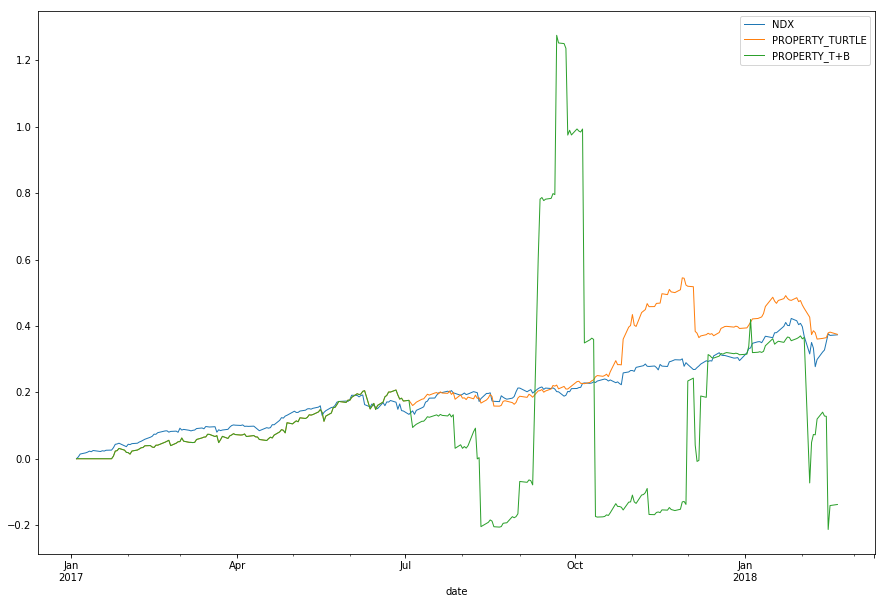

In [13]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

df = show_df.dropna(how='any', inplace=False).copy()

# fc = df.iloc[0]['close']
# df.loc[:, ['close']]

df['close'] = (df['close'] - df.iloc[0]['close']) / df.iloc[0]['close']
df['PROPERTY_TURTLE'] = (df['PROPERTY_TURTLE'] - df.iloc[0]['PROPERTY_TURTLE']) / df.iloc[0]['PROPERTY_TURTLE']
df['PROPERTY_T+B'] = (df['PROPERTY_T+B'] - df.iloc[0]['PROPERTY_T+B']) / df.iloc[0]['PROPERTY_T+B']

ax = df.plot(kind='line', y='close', label='NDX', linewidth=1)
ax = df.plot(kind='line', y='PROPERTY_TURTLE', secondary_y=False, label='PROPERTY_TURTLE', linewidth=1, ax=ax)
ax = df.plot(kind='line', y='PROPERTY_T+B', secondary_y=False, label='PROPERTY_T+B', linewidth=1, ax=ax)

# for symbol, stock_df in stock_df_dict.items():
#     df = stock_df.copy()
#     df['close'] = (df['close'] - df.head(1)['close'].values) / df.head(1)['close'].values
#     ax = df.plot(kind='line', y='close', secondary_y=False, label=symbol, linewidth=0.5, ax=ax)

# plt.figure(figsize=(10, 6), dpi=80)
# plt.show()